# **House Price Prediction --- version 2**
***Charles Zhang*** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Jan 19 2020**

In [2]:
from scipy import stats
from scipy.stats import skew,norm  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scipy.stats as stats


#Visualizing tools
import seaborn as sns
import matplotlib.pyplot as plt

#preprocessing tools
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

#ML Algoirthm
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

/Users/apple/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
test = pd.read_csv("https://raw.githubusercontent.com/zcczhang/House_Price_Prediction_Model/master/input/test.csv")
train = pd.read_csv("https://raw.githubusercontent.com/zcczhang/House_Price_Prediction_Model/master/input/train.csv")
train_size = train.shape[0]
submission = pd.read_csv("https://raw.githubusercontent.com/zcczhang/House_Price_Prediction_Model/master/input/sample_submission.csv")

import warnings
warnings.filterwarnings(action="ignore")

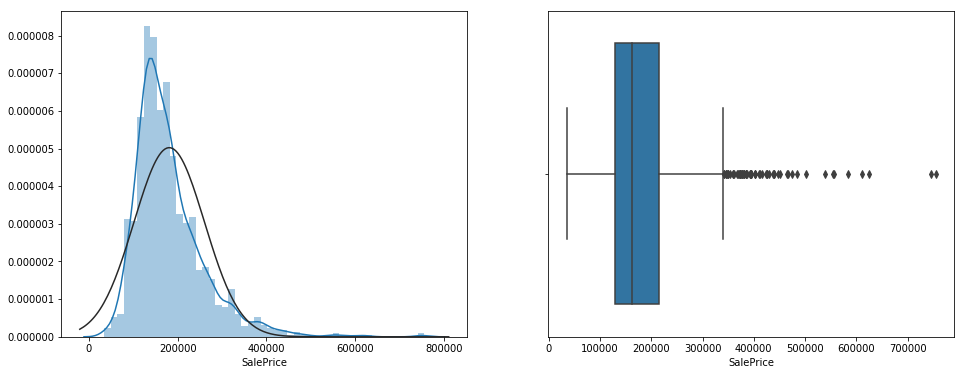

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529
--------------------------------------
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [4]:
f,ax = plt.subplots(1,2,figsize=(16,6))
sns.distplot(train['SalePrice'],fit=norm,ax=ax[0])
sns.boxplot(train['SalePrice'])
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(train['SalePrice'].skew()))
print("Kurtosis: {}".format(train['SalePrice'].kurt()))
print("--------------------------------------")
print(train['SalePrice'].describe())

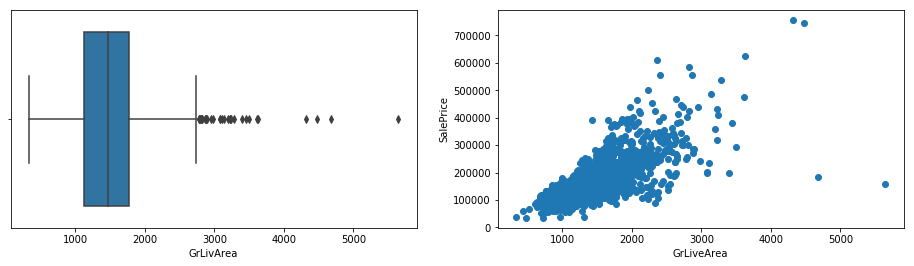

In [5]:
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train['GrLivArea'],ax=ax[0])
plt.scatter(train['GrLivArea'],train['SalePrice'])
plt.xlabel('GrLiveArea')
plt.ylabel('SalePrice')
plt.show()

In [6]:
train.drop(train[train['GrLivArea']>4500].index,axis=0,inplace=True)

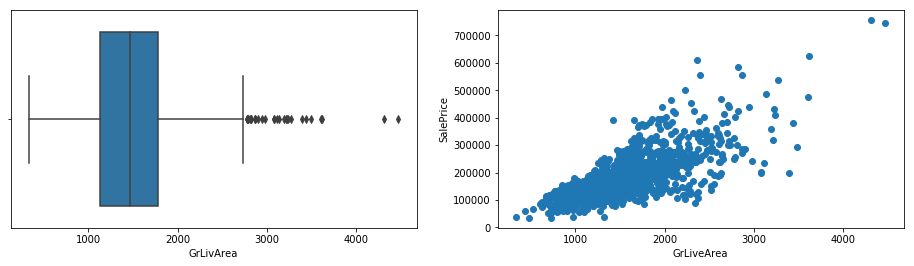

In [7]:
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train['GrLivArea'],ax=ax[0])
plt.scatter(train['GrLivArea'],train['SalePrice'])
plt.xlabel('GrLiveArea')
plt.ylabel('SalePrice')
plt.show()

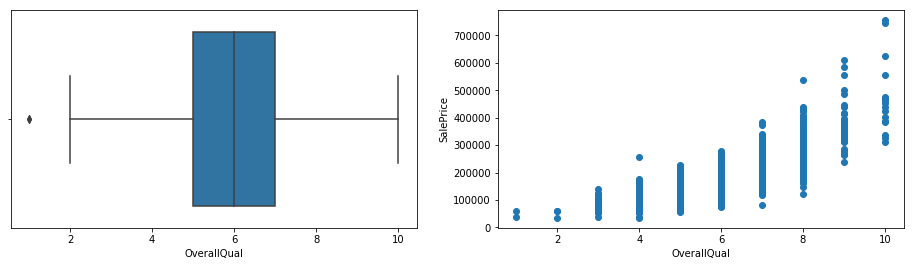

In [8]:
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train['OverallQual'],ax=ax[0])
plt.scatter(train['OverallQual'],train['SalePrice'])
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.show()

AttributeError: module 'seaborn' has no attribute 'scatterplot'

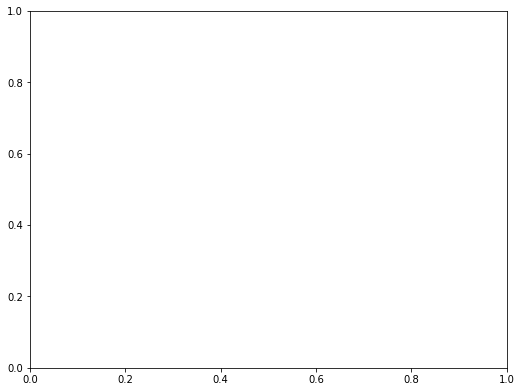

In [9]:
# Finding numeric features
numeric_cols = train.select_dtypes(exclude='object').columns
numeric_cols_length = len(numeric_cols)  

fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

# skiped Id and saleprice feature
for i in range(1,numeric_cols_length-1):
    feature = numeric_cols[i]
    plt.subplot(numeric_cols_length, 3, i)
    sns.scatterplot(x=feature, y='SalePrice', data=train)
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
           
plt.show()


In [ ]:
corr = train.select_dtypes(include='number').corr()
plt.figure(figsize=(16,6))
corr['SalePrice'].sort_values(ascending=False)[1:].plot(kind='bar')
plt.tight_layout()

In [ ]:
# Correlation of top 10 feature with saleprice
corWithSalePrice = train.corr().nlargest(10,'SalePrice')['SalePrice'].index
f , ax = plt.subplots(figsize = (18,12))
ax = sns.heatmap(train[corWithSalePrice].corr(), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [ ]:
f,ax = plt.subplots(1,3,figsize=(16,4))
sns.scatterplot('GrLivArea','TotRmsAbvGrd',data=train,ax=ax[0])
sns.scatterplot('TotalBsmtSF','1stFlrSF',data=train,ax = ax[1])
sns.scatterplot('GarageCars','GarageArea',data=train,ax = ax[2])
plt.show()

In [ ]:
f,ax = plt.subplots(1,3,figsize=(16,4))
sns.scatterplot(x='TotalBsmtSF', y='SalePrice',data=train,ax=ax[0])
sns.scatterplot(x='LotArea', y='SalePrice',data=train,ax=ax[1])
sns.scatterplot(x='OverallQual', y='SalePrice',data=train,ax=ax[2])
plt.show()


In [ ]:
# After removing the two outliers, you can see that skewness is reduced. Still Saleprice is not normally distributed.
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.distplot(train['SalePrice'],ax=ax[0],fit=norm)
stats.probplot(train['SalePrice'],plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(train['SalePrice'].skew()))
print("Kurtosis: {}".format(train['SalePrice'].kurt()))

In [ ]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [ ]:
#Log - transformation
y = np.log1p(train['SalePrice'])

f,ax = plt.subplots(1,2,figsize=(16,4))
sns.distplot(y,fit=norm,ax=ax[0])
stats.probplot(y,plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(y.skew()))
print("Kurtosis: {}".format(y.kurt()))

In [ ]:
def remove_overfit_features(df,weight):
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > weight:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = remove_overfit_features(train,99)
train.drop(overfitted_features,inplace=True,axis=1)
test.drop(overfitted_features,inplace=True,axis=1)


In [ ]:
train_labels = y
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [ ]:
#visualize missing data
missing_value = all_features.isnull().sum().sort_values(ascending=False) / len(all_features) * 100
missing_value = missing_value[missing_value != 0]
missing_value = pd.DataFrame({'Missing value' :missing_value,'Type':missing_value.index.map(lambda x:all_features[x].dtype)})
missing_value.plot(kind='bar',figsize=(16,4))
plt.show()

In [ ]:
print("Total No. of missing value {} before Imputation".format(sum(all_features.isnull().sum())))
def fill_missing_values():
 
    fillSaleType = all_features[all_features['SaleCondition'] == 'Normal']['SaleType'].mode()[0]
    all_features['SaleType'].fillna(fillSaleType,inplace=True)

    fillElectrical = all_features[all_features['Neighborhood']=='Timber']['Electrical'].mode()[0]
    all_features['Electrical'].fillna(fillElectrical,inplace=True)

    exterior1_neighbor = all_features[all_features['Exterior1st'].isnull()]['Neighborhood'].values[0]
    fillExterior1 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
    all_features['Exterior1st'].fillna(fillExterior1,inplace=True)

    exterior2_neighbor = all_features[all_features['Exterior2nd'].isnull()]['Neighborhood'].values[0]
    fillExterior2 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
    all_features['Exterior2nd'].fillna(fillExterior2,inplace=True)

    bsmtNeigh = all_features[all_features['BsmtFinSF1'].isnull()]['Neighborhood'].values[0]
    fillBsmtFinSf1 = all_features[all_features['Neighborhood'] == bsmtNeigh]['BsmtFinSF1'].mode()[0]
    all_features['BsmtFinSF1'].fillna(fillBsmtFinSf1,inplace=True)

    kitchen_grade = all_features[all_features['KitchenQual'].isnull()]['KitchenAbvGr'].values[0]
    fillKitchenQual = all_features[all_features['KitchenAbvGr'] == kitchen_grade]['KitchenQual'].mode()[0]
    all_features['KitchenQual'].fillna(fillKitchenQual,inplace=True)
        
    all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
       
    all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2','PoolQC']:
        all_features[col] = all_features[col].fillna('None')
    
    categorical_cols =  all_features.select_dtypes(include='object').columns
    all_features[categorical_cols] = all_features[categorical_cols].fillna('None')
    
    numeric_cols = all_features.select_dtypes(include='number').columns
    all_features[numeric_cols] = all_features[numeric_cols].fillna(0)
    
    all_features['Shed'] = np.where(all_features['MiscFeature']=='Shed', 1, 0)
    
    #GarageYrBlt -  missing values there for the building which has no Garage, imputing 0 makes huge difference with other buildings,
    #imputing mean doesn't make sense since there is no Garage. So we'll drop it
    all_features.drop(['GarageYrBlt','MiscFeature'],inplace=True,axis=1)
    
    all_features['QualitySF'] = all_features['GrLivArea'] * all_features['OverallQual']

fill_missing_values()

print("Total No. of missing value {} after Imputation".format(sum(all_features.isnull().sum())))

In [ ]:
all_features = all_features.drop(['PoolQC',], axis=1)

In [ ]:
# converting some numeric features to string
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)


# Filter the skewed features
numeric = all_features.select_dtypes(include='number').columns
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

In [ ]:
# Normalize skewed features using boxcox
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [ ]:
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']

all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])

all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

In [ ]:
def booleanFeatures(columns):
    for col in columns:
        all_features[col+"_bool"] = all_features[col].apply(lambda x: 1 if x > 0 else 0)
booleanFeatures(['GarageArea','TotalBsmtSF','2ndFlrSF','Fireplaces','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'])  


In [ ]:
def logs(columns):
    for col in columns:
        all_features[col+"_log"] = np.log(1.01+all_features[col])  

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','MiscVal','YearRemodAdd','TotalSF']

logs(log_features)


In [ ]:
def squares(columns):
    for col in columns:
        all_features[col+"_sq"] =  all_features[col] * all_features[col]

squared_features = ['GarageCars_log','YearRemodAdd', 'LotFrontage_log', 'TotalBsmtSF_log', '2ndFlrSF_log', 'GrLivArea_log' ]

squares(squared_features)

In [ ]:
# There is a natural order in their values for few categories, so converting them to numbers gives more meaning
quality_map = {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
quality_cols = ['BsmtQual', 'BsmtCond','ExterQual', 'ExterCond','FireplaceQu','GarageQual', 'GarageCond','KitchenQual','HeatingQC']
for col in quality_cols:
    all_features[col] = all_features[col].replace(quality_map)

all_features['BsmtExposure'] = all_features['BsmtExposure'].replace({"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3})

all_features["PavedDrive"] =all_features["PavedDrive"].replace({"N" : 0, "P" : 1, "Y" : 2})

bsmt_ratings = {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
bsmt_col = ['BsmtFinType1','BsmtFinType2']
for col in bsmt_col:
    all_features[col] = all_features[col].replace(bsmt_ratings)

    
all_features["OverallScore"]   = all_features["OverallQual"] * all_features["OverallCond"]
all_features["GarageScore"]    = all_features["GarageQual"] * all_features["GarageCond"]
all_features["ExterScore"]     = all_features["ExterQual"] * all_features["ExterCond"]


In [ ]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)

In [ ]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
train_labels = train_labels.drop(y.index[outliers])


In [ ]:
overfitted_features = remove_overfit_features(X,99)

X = X.drop(overfitted_features, axis=1)
X_test = X_test.drop(overfitted_features, axis=1)

In [ ]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [ ]:
# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)


# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006,random_state=42)

# StackingCVRegressor 
stackReg = StackingCVRegressor(regressors=(xgboost, svr, ridge, gbr),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True,random_state=42)

In [ ]:
model_score = {}

score = cv_rmse(lightgbm)
lgb_model_full_data = lightgbm.fit(X, train_labels)
print("lightgbm: {:.4f}".format(score.mean()))
model_score['lgb'] = score.mean()

In [ ]:
score = cv_rmse(xgboost)
xgb_model_full_data = xgboost.fit(X, train_labels)
print("xgboost: {:.4f})".format(score.mean()))
model_score['xgb'] = score.mean()

In [ ]:
score = cv_rmse(svr)
svr_model_full_data = svr.fit(X, train_labels)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['svr'] = score.mean()


In [ ]:
score = cv_rmse(ridge)
ridge_model_full_data = ridge.fit(X, train_labels)
print("ridge: {:.4f}".format(score.mean()))
model_score['ridge'] =  score.mean()


In [ ]:
score = cv_rmse(gbr)
gbr_model_full_data = gbr.fit(X, train_labels)
print("gbr: {:.4f}".format(score.mean()))
model_score['gbr'] =  score.mean()


In [ ]:
stack_reg_model = stackReg.fit(np.array(X), np.array(train_labels))

In [ ]:
def blended_predictions(X,weight):
    return ((weight[0] * ridge_model_full_data.predict(X)) + \
            (weight[1] * svr_model_full_data.predict(X)) + \
            (weight[2] * gbr_model_full_data.predict(X)) + \
            (weight[3] * xgb_model_full_data.predict(X)) + \
            (weight[4] * lgb_model_full_data.predict(X)) + \
            (weight[5] * stack_reg_model.predict(np.array(X))))


In [ ]:
# Blended model predictions
blended_score = rmsle(train_labels, blended_predictions(X,[0.15,0.2,0.1,0.15,0.1,0.3]))
print("blended score: {:.4f}".format(blended_score))
model_score['blended_model'] =  blended_score


In [ ]:
pd.Series(model_score).sort_values(ascending=True)

In [ ]:
# Read submission csv
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
# Predictions
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_test,[0.15,0.2,0.1,0.15,0.1,0.3])))

In [ ]:
# Write to csv
submission.to_csv("submission.csv", index=False)